# MHPI hydroDL Tutorial

This deep learning code can be used to model hydrologic systems from soil moisture to streamflow or from projection to forecast. If this work is useful to you, please cite
Liu, Jiangtao, David Hughes, Farshid Rahmani, Kathryn Lawson and Chaopeng Shen,

*   Evaluating a Global Soil Moisture dataset from a Multitask Model (GSM3 v1.0) for current and emerging threats to crops, Geoscientific Model Development (2023), doi: 10.5194/gmd-16-1553-2023 &
*   Fang, K., CP. Shen, D. Kifer and X. Yang, Prolongation of SMAP to Spatio-temporally Seamless Coverage of Continental US Using a Deep Learning Neural Network, Geophysical Research Letters, doi: 10.1002/2017GL075619, preprint accessible at: arXiv:1707.06611 (2017)

--- Chaopeng Shen, Jiangtao Liu, Yalan Song & Kuai Fang

[![PyPI](https://img.shields.io/badge/pypi-version%200.1-blue)](https://pypi.org/project/hydroDL/0.1.0/)  [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3993880.svg)](https://doi.org/10.5281/zenodo.3993880) [![CodeStyle](https://img.shields.io/badge/code%20style-Black-black)]()



Welcome to our hydroDL tutorial at The Pennsylvania State University! The following notebook is designed to provide a quick start to our project and get you ready to write your own neural networks.

### Configure Model

In [1]:
# the model formulation is y = LSTM(x, c) where x is
import os
import torch
import numpy as np

import sys
# sys.path.append('..')

#from hydroDL.model.train import trainModel
from hydroDL.model.test import testModel
from hydroDL.post.stat import statError as cal_metric
from hydroDL.data.load_csv import LoadCSV
from hydroDL.utils.norm import re_folder, trans_norm


# set configuration
output_s = "./output/quick_start/"  # output path
csv_path_s = "./example/demo_data/"  # demo data path
all_date_list = ["2015-04-01", "2017-03-31"]  # demo data time period
train_date_list = ["2015-04-01", "2016-03-31"]  # training period
# time series variables list
var_time_series = ["VGRD_10_FORA", "DLWRF_FORA", "UGRD_10_FORA", "DSWRF_FORA", "TMP_2_FORA", "SPFH_2_FORA", "APCP_FORA", ]
# constant variables list
var_constant = ["flag_extraOrd", "Clay", "Bulk", "Sand", "flag_roughness", "flag_landcover", "flag_vegDense", "Silt", "NDVI",
         "flag_albedo", "flag_waterbody", "Capa", ]
# target variable list
target = ["SMAP_AM"]

# generate output folder
re_folder(output_s)

# load your datasets
"""
You can change it with your data. The data structure is as follows:
x_train (forcing data, e.g. precipitation, temperature ...): [pixels, time, features]
c_train (constant data, e.g. soil properties, land cover ...): [pixels, features]
target (e.g. soil moisture, streamflow ...): [pixels, time, 1]

Data type: numpy.float
We have normalized the raw data.
example:
    If the data size is "[pixels, time, features]" or "[pixels, features]", the statistics for 10% to 90% of the data are calculated as follows:

    from hydroDL.utils.norm import cal_statistics
    stat_list = cal_statistics(data, re_extreme=True, percent=10)
    [left_p10, left_p90, mean, std] = stat_list
"""
train_csv = LoadCSV(csv_path_s, train_date_list, all_date_list)
x_train = train_csv.load_time_series(var_time_series)  # data size: [pixels, time, features]
c_train = train_csv.load_constant(var_constant, convert_time_series=False)  # [pixels, features]
y_train = train_csv.load_time_series(target, remove_nan=False)  # [pixels, time, 1]

# validation the result
# load validation datasets
val_date_list = ["2016-04-01", "2017-03-31"]  # validation period
# load your data. same as training data
val_csv = LoadCSV(csv_path_s, val_date_list, all_date_list)
x_val = val_csv.load_time_series(var_time_series)
c_val = val_csv.load_constant(var_constant, convert_time_series=False)
y_val = val_csv.load_time_series(target, remove_nan=False)


loading package hydroDL


In [2]:
print(type(x_train))
print(x_train.shape, c_train.shape, y_train.shape)
print(x_val.shape, c_val.shape, y_val.shape)

<class 'numpy.ndarray'>
(412, 366, 7) (412, 12) (412, 366, 1)
(412, 365, 7) (412, 12) (412, 365, 1)


In [3]:
'''
load_data is the Dataloader function for the training function. These functions are typically embedded inside the hydroDL package,
but they are pulled out here so that newcomers can understand them without packaging details.
They help to build the minibatch and copy to cuda() device
Here we extract a minibatch from inputs["x", "c", "y"] and wrap the extracted data to data["x", "yTrain"]
'''
from hydroDL.master.master import loadModel
from hydroDL.model.crit import RmseLoss
from hydroDL.model.rnn import CudnnLstmModel
from hydroDL.model.rnn import CpuLstmModel
from hydroDL.model.crit import RmseLoss, NSELossBatch,NSESqrtLossBatch
from hydroDL.model.settings import make_train_settings
import pandas as pd
from time import sleep
from tqdm import trange
import hydroDL.core.logger as logger
from hydroDL.model import crit
import time
log = logger.get_logger("model.train_.train")

def select_subset(
    x, iGrid, iT, rho, c=None, tupleOut=False, LCopt=False, bufftime=0, **kwargs
):
    """
    Selects a subset based on the grid given
    :param x:
    :param iGrid:
    :param iT:
    :param rho:
    :param c:
    :param tupleOut:
    :param LCopt:
    :param bufftime:
    :return:
    """
    nx = x.shape[-1]
    nt = x.shape[1]
    if x.shape[0] == len(iGrid):  # hack
        iGrid = np.arange(0, len(iGrid))  # hack
    if nt <= rho:
        iT.fill(0)
    batchSize = iGrid.shape[0]
    if iT is not None:
        # batchSize = iGrid.shape[0]
        xTensor = torch.zeros([rho + bufftime, batchSize, nx], requires_grad=False)
        for k in range(batchSize):
            temp = x[
                iGrid[k] : iGrid[k] + 1, np.arange(iT[k] - bufftime, iT[k] + rho), :
            ]
            xTensor[:, k : k + 1, :] = torch.from_numpy(np.swapaxes(temp, 1, 0))
    else:
        if LCopt is True:
            # used for local calibration kernel: FDC, SMAP...
            if len(x.shape) == 2:
                # Used for local calibration kernel as FDC
                # x = Ngrid * Ntime
                xTensor = torch.from_numpy(x[iGrid, :]).float()
            elif len(x.shape) == 3:
                # used for LC-SMAP x=Ngrid*Ntime*Nvar
                xTensor = torch.from_numpy(np.swapaxes(x[iGrid, :, :], 1, 2)).float()
        else:
            # Used for rho equal to the whole length of time series
            xTensor = torch.from_numpy(np.swapaxes(x[iGrid, :, :], 1, 0)).float()
            rho = xTensor.shape[0]
    if c is not None:
        nc = c.shape[-1]
        temp = np.repeat(
            np.reshape(c[iGrid, :], [batchSize, 1, nc]), rho + bufftime, axis=1
        )
        cTensor = torch.from_numpy(np.swapaxes(temp, 1, 0)).float()
        if tupleOut:
            if torch.cuda.is_available():
                xTensor = xTensor.cuda()
                cTensor = cTensor.cuda()
            out = (xTensor, cTensor)
        else:
            out = torch.cat((xTensor, cTensor), 2)
    else:
        out = xTensor
    if torch.cuda.is_available() and type(out) is not tuple:
        out = out.cuda()
    return out


def random_index(ngrid, nt, dimSubset, bufftime=0):
    """
    Finds a random place to start inside of the grids
    :param: ngrid: the number of grids
    :param: nt: the number of tiles
    :param: dimSubset: the dimensions of the subset
    :param: bufftime: a buffer
    :returns: the index of the grid and the index of the tile
    """
    batchSize, rho = dimSubset
    iGrid = np.random.randint(0, ngrid, [batchSize])
    iT = np.random.randint(0 + bufftime, nt - rho, [batchSize])
    return iGrid, iT

def save_model(outFolder, model, epoch, modelName="model"):
    modelFile = os.path.join(outFolder, modelName + "_Ep" + str(epoch) + ".pt")
    torch.save(model, modelFile)


def load_model(outFolder, epoch, modelName="model"):
    modelFile = os.path.join(outFolder, modelName + "_Ep" + str(epoch) + ".pt")
    model = torch.load(modelFile)
    return model

def load_data(inputs, settings):
    """

    :param inputs:
    :param settings:
    :return:
    """
    data = {}
    iGrid, iT = random_index(
        settings["ngrid"], settings["nt"], [settings["batchSize"], settings["rho"]], bufftime=settings['bufftime']
    )
    data["x"] = select_subset(inputs["x"], iGrid, iT, settings["rho"], c=inputs["c"], bufftime=settings['bufftime'])
    data["yTrain"] = select_subset(inputs["y"], iGrid, iT, settings["rho"])
    return data, iGrid


import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def trainModel(
    model,
    x,
    y,
    c,
    lossFun,
    nEpoch=500,
    load_data=load_data,
    miniBatch=[100, 30],
    saveEpoch=100,
    saveFolder=None,
    mode="seq2seq",
    bufftime=0,
):
    optim = torch.optim.Adadelta(model.parameters())
    if saveFolder is not None:
        runFile = os.path.join(saveFolder, "run.csv")
        rf = open(runFile, "w+")
    inputs, settings = make_train_settings(model, x, y, c, nEpoch, miniBatch, bufftime,)
    # wrap data into a dict (inputs).

    if torch.cuda.is_available():
        lossFun = lossFun.cuda()

    losses = []
    plt.figure()

    with trange(1, nEpoch + 1) as pbar:
        for iEpoch in pbar:
            pbar.set_description(f"Training {model.name}")
            lossEp = 0
            t0 = time.time()
            for iIter in range(0, settings["nIterEp"]):
                model.zero_grad()
                dataDict, iGrid = load_data(inputs, settings)
                x = dataDict["x"]
                yp = model(x)

                if type(lossFun) in [NSELossBatch, NSESqrtLossBatch]:
                    loss = lossFun(yp[bufftime:, :, :], dataDict["yTrain"], igrid=iGrid)
                else:
                    loss = lossFun(yp[bufftime:, :, :], dataDict["yTrain"])

                loss.backward()
                optim.step()
                lossEp += loss.item()

            lossEp /= settings["nIterEp"]
            losses.append(lossEp)
            loss_str = "Epoch {} Loss {:.3f} time {:.2f}".format(
                iEpoch, lossEp, time.time() - t0
            )
            print(loss_str)
            log.debug(loss_str)
            pbar.set_postfix(loss=lossEp)

            # Live plot update
            clear_output(wait=True)
            plt.plot(losses, label='Training Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss Over Time')
            # plt.legend()
            display(plt.gcf())
            sleep(0.1)

            if saveFolder is not None:
                rf.write(loss_str + "\n")
                if iEpoch % saveEpoch == 0:
                    # save model
                    modelFile = os.path.join(
                        saveFolder, "model_Ep" + str(iEpoch) + ".pt"
                    )
                    torch.save(model, modelFile)
    if saveFolder is not None:
        rf.close()

    plt.close()  # Close the dynamic plot
    return model


# define model and loss function
loss_fn = RmseLoss()  # loss function
# select model: GPU or CPU
device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu" )

# hyperparameter
EPOCH = 100 # go to 300 if you have the time to wait.
BATCH_SIZE = 50
RHO = 30
HIDDEN_SIZE = 256
nx = x_train.shape[-1] + c_train.shape[-1]  # update nx, nx = nx + nc
ny = y_train.shape[-1]
nmodes = 12
if torch.cuda.is_available():
    model = CudnnLstmModel(nx=nx, ny=ny, hiddenSize=HIDDEN_SIZE).to(device)
else:
    model = CpuLstmModel(nx=nx, ny=ny, hiddenSize=HIDDEN_SIZE).to(device)
# If you want to read LSTM internal code
# The CpuLstmModel eventually calls LSTMcell_tied in hydroDLpack/hydroDL/model/rnn/CpuLstmModel, which is the most interpretable version
# The CudnnLstmModel version calls hydroDLpack/hydroDL/model/rnn/CudnnLstm which wraps the cudnn library and is super fast

### Train Model

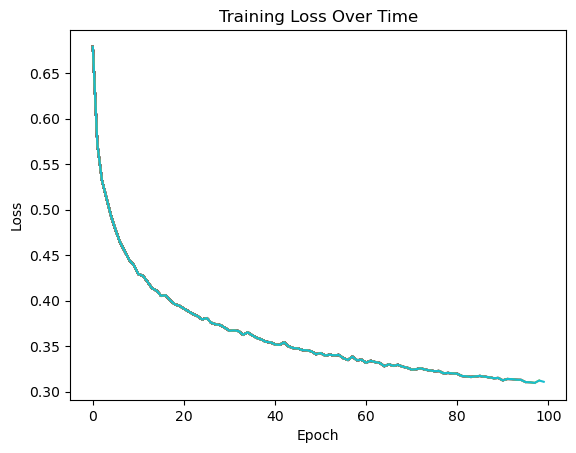

Training CudnnLstmModel: 100%|██████████| 100/100 [06:43<00:00,  4.04s/it, loss=0.311]


In [4]:
# training the model
last_model = trainModel(
    model,
    x_train,
    y_train,
    c_train,
    loss_fn,
    nEpoch=EPOCH,
    miniBatch=[BATCH_SIZE, RHO],
    saveEpoch=100,
    saveFolder=output_s,
    bufftime=0
)
val_epoch = EPOCH # Select the epoch for testing


### Save and Test Model

In [5]:
# load the model
test_model = loadModel(output_s, epoch=val_epoch)

# set the path to save result
save_csv = os.path.join(output_s, "predict.csv")

# validation
pred_val = testModel(test_model, x_val, c_val, batchSize=len(x_train), filePathLst=[save_csv],)

# select the metrics
metrics_list = ["Bias", "RMSE", "ubRMSE", "Corr"]
pred_val = pred_val.numpy()
# denormalization
pred_val = trans_norm(pred_val, csv_path_s, var_s=target[0], from_raw=False)
y_val = trans_norm(y_val, csv_path_s, var_s=target[0], from_raw=False)
pred_val, y_val = np.squeeze(pred_val), np.squeeze(y_val)
metrics_dict = cal_metric(pred_val, y_val)  # calculate the metrics
metrics = ["Median {}: {:.4f}".format(x, np.nanmedian(metrics_dict[x])) for x in metrics_list]
print("Epoch {}: {}".format(val_epoch, metrics))

/storage/work/amb10399/test/hydroDLpack/hydroDL/post/stat.py:80: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  Corr[k] = scipy.stats.pearsonr(xx, yy)[0]
/storage/work/amb10399/test/hydroDLpack/hydroDL/post/stat.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  CorrSp[k] = scipy.stats.spearmanr(xx, yy)[0]


Epoch 100: ['Median Bias: 0.0019', 'Median RMSE: 0.0308', 'Median ubRMSE: 0.0304', 'Median Corr: 0.8439']


When we ran this code with the default data, our results for epoch 100 were
*   Median Bias: 0.0046
*   Median root-mean-square error (RMSE): 0.0316
*   Median unbiased RMSE (ubRMSE): 0.0307
*   Median Correlation: 0.8409

Your results with our default settings should be fairly close to these, but won't be exactly the same.

### Plot Results

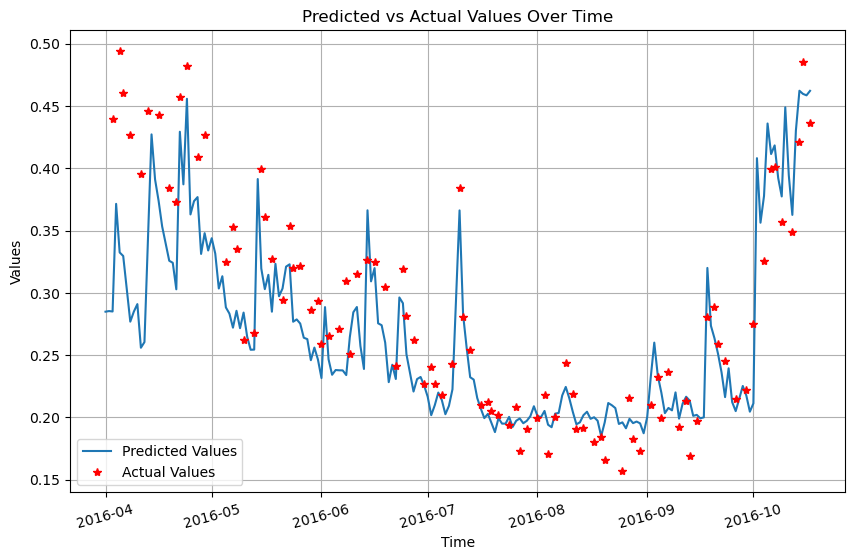

In [6]:
import matplotlib.pyplot as plt

# Obtaining list of dates and data for one basin to plot
plot_date_list = pd.date_range(val_date_list[0], val_date_list[1])
plot_pred_val = pred_val[1,:] # 0 is the index number of the desired basin
plot_y_val = y_val[1,:] # 0 is the index number of the desired basin

# Defining plot data and characteristics
plt.figure(figsize=(10, 6))
plt.plot(plot_date_list[0:200], plot_pred_val[0:200], label='Predicted Values') # only plot first 200 days
plt.plot(plot_date_list[0:200], plot_y_val[0:200], 'r*', label='Actual Values') # only plot first 200 days
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation = 15)
plt.show()

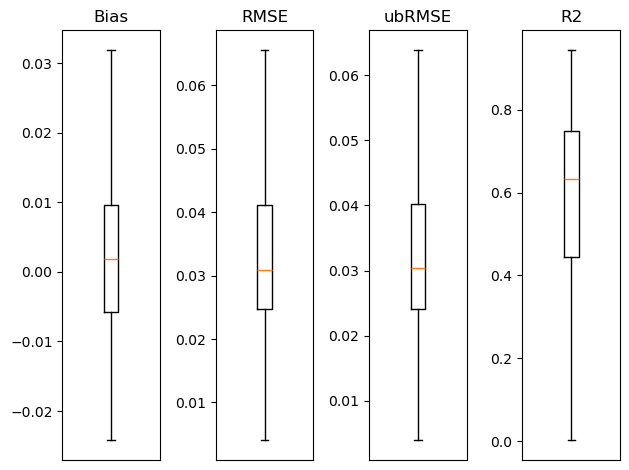

In [7]:
statDictLst = [metrics_dict]

dataBox = list()
for i in range(len(metrics_list)):
    statStr = metrics_list[i]
    temp = list()
    for k in range(len(statDictLst)):
        data = statDictLst[k][statStr]
        data = data[~np.isnan(data)]
        temp.append(data)
    dataBox.append(temp)

# Defining list of metrics to plot
metrics_list_plot = ["Bias", "RMSE", "ubRMSE", "R2"]
metrics_plot = [metrics_dict[key] for key in metrics_list_plot]

percent=10
left_p10 = np.nanpercentile(data, percent, interpolation="nearest")
left_p90 = np.nanpercentile(data, 100 - percent, interpolation="nearest")
#data_80p = data[(data >= left_p10) & (data <= left_p90)]

# Creating subplots with different axes for each boxplot
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_list_plot))

# Plotting boxplots for each dataset on different axes

for x in range(len(metrics_list)):
  axes[x].boxplot(metrics_plot[x], showfliers=False)
  axes[x].set_title(metrics_list_plot[x])
  axes[x].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()